In [3]:
import numpy as np, cv2, matplotlib.pyplot as plt, os.path

In [4]:
img = cv2.imread("../../Images_Data/AV81_DAPI.tif"); print("shape", img.shape)
img = cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)

shape (2048, 2048, 3)


In [5]:
clone = img.copy(); show_clone = clone.copy()
all_segments = []
this_crop = np.empty((0,2),dtype = int)
new_crop = True
cropping = False
accept = False
crop_num = 0 
reset = False
boundary_mode = True
continuous_mode = False
erase_mode = False

In [6]:
def cell_crop(event, x, y, flags, param):
    global clone, show_clone, crop_num, all_segments, new_crop, cropping, this_crop, last_img, cropping, accept, reset, contour
    global boundary_mode, continuous_mode
    
    if not cropping and accept:
        if not boundary_mode:
            clone = cv2.drawContours(clone, [all_segments[-1]], -1, (150, 255,0), -1, cv2.LINE_AA)
        else:
            clone = cv2.drawContours(clone, [all_segments[-1]], -1, (150, 255,150), 2, cv2.LINE_AA)
        print("Segment accepted")
        cv2.imshow("image", clone)
        last_img = clone.copy()
        show_clone = clone.copy()
        accept = False
        
    elif event == cv2.EVENT_LBUTTONDOWN:    
        if not cropping and new_crop == True:
            last_img = clone.copy();
            this_crop = np.empty((0,2),dtype = int)
            crop_num += 1; print('Crop', crop_num)
            new_crop = False
            cropping = True
            accept = False       
            
        this_crop = np.append(this_crop, np.array([[x, y]]), axis = 0)
        clone = show_clone
        cv2.imshow("image", clone)
        
    elif event == cv2.EVENT_MOUSEMOVE:
        if cropping and not new_crop:
            show_clone = clone.copy()
            last_coord = this_crop[-1]
            cv2.line(show_clone,(x,y),tuple(last_coord),(0,0,255),4) # draw line between former and present pixel
            cv2.imshow("image", show_clone)


In [7]:
cv2.namedWindow("image", cv2.WINDOW_NORMAL|cv2.WND_PROP_ASPECT_RATIO); cv2.setMouseCallback("image", cell_crop)
cv2.imshow("image", clone)
# keep looping until the 'q' key is pressed
while True:
    # display the image and wait for a keypress
    key = cv2.waitKey() #1) & 0xFF
    if key == ord("r"):
        if not cropping:
            continue
        else:
            clone = last_img
            show_clone = last_img
            new_crop = True
            cropping = False
            started = False
            crop_num -= 1
            
    elif key == ord("a"):  # accept
        all_segments.append(this_crop)
        show_clone = clone.copy
        new_crop = True
        cropping = False
        accept = True
        
    elif key == ord("s") and not cropping:   # save
        if not os.path.isdir("Output"):
            os.makedirs("Output")
        if len(all_segments) != 0:
            fid = 0
            file_name = "\Output\Output_CropCoordinates_"+str(fid)
            file_path = os.getcwd()+file_name
            while os.path.exists(file_path+'.csv'):
                fid += 1
                file_path = file_path[:-1] + str(fid)
            
            with open(file_path+'.csv', 'w', newline = '') as f_out:
                for seg in all_segments:
                    for i in range(len(seg)):
                        f_out.write(str(seg[i][0])+','+str(seg[i][1])+'\t')
                    f_out.write('\n')
            contour_mask = (clone[:,:,1]==255).astype('uint8')*255
            cv2.imwrite(os.getcwd()+"\Output\Output_Mask_"+str(fid)+".png", contour_mask)
            #m2, contours, hierarchy = cv2.findContours(contour_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
            #rint(im2.shape)
            #v2.imwrite(os.getcwd()+"\Output\Output_boundary_"+str(fid)+".png", im2)
            #np.savetxt('bounds.csv',contours,fmt='%s')
            print("Coordinates are saved to:", file_name+'.csv')
            print("Mask is saved to", os.getcwd()+"\Output\Output_Mask_"+str(fid))
        else:
            print("File not saved")
            
    elif key == ord("b"):
        if boundary_mode:
            boundary_mode = False
        else:
            boundary_mode = True
    
                        
    elif key == 27 or key == ord("q"):  # Quit
        new_crop = True
        cropping = False
        accept = True
        break
    
    cv2.imshow("image", clone)
cv2.destroyAllWindows()

Crop 1
Crop 1


Create Mask

In [16]:
with open("../Cell_CropnSegmentation/Output/Output_CropCoordinates_0.csv") as f:
    line = f.readline()
    while line:
        line = f.readline()
        arr = line.split('\t')[:-1]
        for coord in arr:
            x, y = map(int,(coord.split(',')))
            print(x, y)

1098 759
1097 784
1113 788
1126 771
1120 763
1111 759
1332 695
1338 710
1349 711
1355 711
1360 705
1356 701
1358 691
1355 684
1345 681
1336 689


<b> Other Functions

In [7]:
def CircleErase_Kernel(center=(0,0), r = 4):
    for i in range(center[0]-r, center[0]+r):
        for j in range(center[1]-r, center[1] + r):
            if (center[0] - i) ** 2 + (center[1] - j) ** 2 <= r**2:
                if img[i][j][:,:,1] == 255:
                    img[i][j][:,:,1] == np.average([img[i][j][:,:,0],img[i][j][:,:,2]])
                    
def CircleErase_Kernel2(radius):
    kernel = np.ones((3,3),np.float32) *(-1)
    kernel[1,1] = 8
    print(kernel)
    dst = cv2.filter2D(img,-1,kernel)

### Example

In [42]:
pts = np.array([[35,10], [750,1000],[231,131]])

## (1) Crop the bounding rect
rect = cv2.boundingRect(pts)
x,y,w,h = rect
croped = img.copy()

## (2) make mask
#pts = pts - pts.min(axis=0)

mask = np.zeros(croped.shape[:2], np.uint8)
cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

## (3) do bit-op
dst = cv2.bitwise_and(croped, croped, mask=mask)

## (4) add the white background
bg = np.ones_like(croped, np.uint8)*255
cv2.bitwise_not(bg,bg, mask=mask)
dst2 = bg+ dst

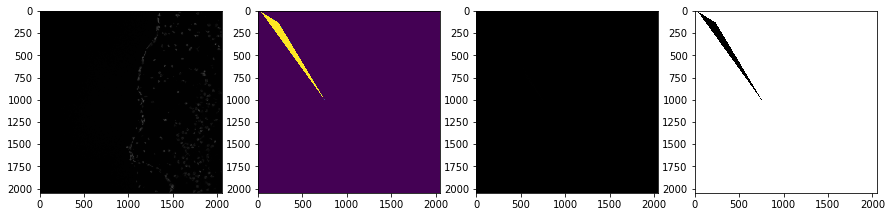

In [102]:
fig, ax = plt.subplots(1,4, figsize=(15,5)); axes = ax.ravel()
images = [croped, mask, dst, bg]
for i, ax in enumerate(axes):
    ax.imshow(images[i])

In [ ]:
cv2.imwrite("croped.png", croped)
cv2.imwrite("mask.png", mask)
cv2.imwrite("dst.png", dst)
cv2.imwrite("dst2.png", dst2)